In [1]:
!pip install -q condacolab

In [2]:
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:25
🔁 Restarting kernel...


In [1]:
!apt-get update
!apt-get install -y cmake build-essential

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:4 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:5 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:7 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:10 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading

In [14]:
!mamba install -c conda-forge python=3.11 cmake scipy six cython numba pillow jupyterlab scikit-learn dask cvxpy zarr pywavelets astra-toolbox tqdm nb_conda_kernels -y -quiet
!mamba install -c ccpi cil-data
!pip install olefile
!pip install dxchange



Looking for: ['python=3.11', 'cmake', 'scipy', 'six', 'cython', 'numba', 'pillow', 'jupyterlab', 'scikit-learn', 'dask', 'cvxpy', 'zarr', 'pywavelets', 'astra-toolbox', 'tqdm', 'nb_conda_kernels']

conda-forge/linux-64                                        Using cache
conda-forge/noarch                                          Using cache

Pinned packages:
  - python 3.11.*
  - python_abi 3.11.* *cp311*
  - cuda-version 12.*


Transaction

  Prefix: /usr/local

  Updating specs:

   - python=3.11
   - cmake
   - scipy
   - six
   - cython
   - numba
   - pillow
   - jupyterlab
   - scikit-learn
   - dask
   - cvxpy
   - zarr
   - pywavelets
   - astra-toolbox
   - tqdm
   - nb_conda_kernels
   - ca-certificates
   - certifi
   - openssl


  Package                                    Version  Build                    Channel           Size
───────────────────────────────────────────────────────────────────────────────────────────────────────
  Install:
────────────────────────────────

In [3]:
!git config --global user.email "github_user_email"
!git config --global user.name "github_user_name"

In [5]:
!git clone https://github.com/epapoutsellis/StochasticCIL.git
%cd StochasticCIL
!git checkout svrg
!git tag -a v1.0 -m "Version 1.0"
!mkdir build
!cd build
!cmake ../ -DCMAKE_POLICY_VERSION_MINIMUM=3.5 -DCONDA_BUILD=OFF -DCMAKE_BUILD_TYPE="Release" -DCMAKE_INSTALL_PREFIX=/usr/local
!make install

Cloning into 'StochasticCIL'...
remote: Enumerating objects: 12572, done.
remote: Counting objects: 100% (1144/1144), done.
remote: Compressing objects: 100% (286/286), done.
remote: Total 12572 (delta 757), reused 1067 (delta 744), pack-reused 11428 (from 1)
Receiving objects: 100% (12572/12572), 25.49 MiB | 28.59 MiB/s, done.
Resolving deltas: 100% (8546/8546), done.
/content/StochasticCIL/StochasticCIL
Branch 'svrg' set up to track remote branch 'svrg' from 'origin'.
Switched to a new branch 'svrg'
CMake Deprecation Warning at CMakeLists.txt:4 (cmake_minimum_required):
  Compatibility with CMake < 3.10 will be removed from a future version of
  CMake.

  Update the VERSION argument <min> value.  Or, use the <min>...<max> syntax
  to tell CMake that the project requires at least <min> but has been updated
  to work with policies introduced by <max> or earlier.


-- The CXX compiler identification is GNU 11.4.0
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - do

In [7]:
%cd ../../

/content


In [10]:
!git clone https://github.com/epapoutsellis/Why-do-we-regularise-in-every-iteration.git

Cloning into 'Why-do-we-regularise-in-every-iteration'...
remote: Enumerating objects: 15344, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 15344 (delta 11), reused 19 (delta 5), pack-reused 15318 (from 3)
Receiving objects: 100% (15344/15344), 242.36 MiB | 27.66 MiB/s, done.
Resolving deltas: 100% (970/970), done.
Updating files: 100% (22455/22455), done.


In [11]:
%cd Why-do-we-regularise-in-every-iteration/deblurring/

/content/Why-do-we-regularise-in-every-iteration/deblurring


Stop at 543 time 172.10430526733398 
Stop at 2326 time 729.5558779239655 
Stop at 2399 time 90.48159527778625 


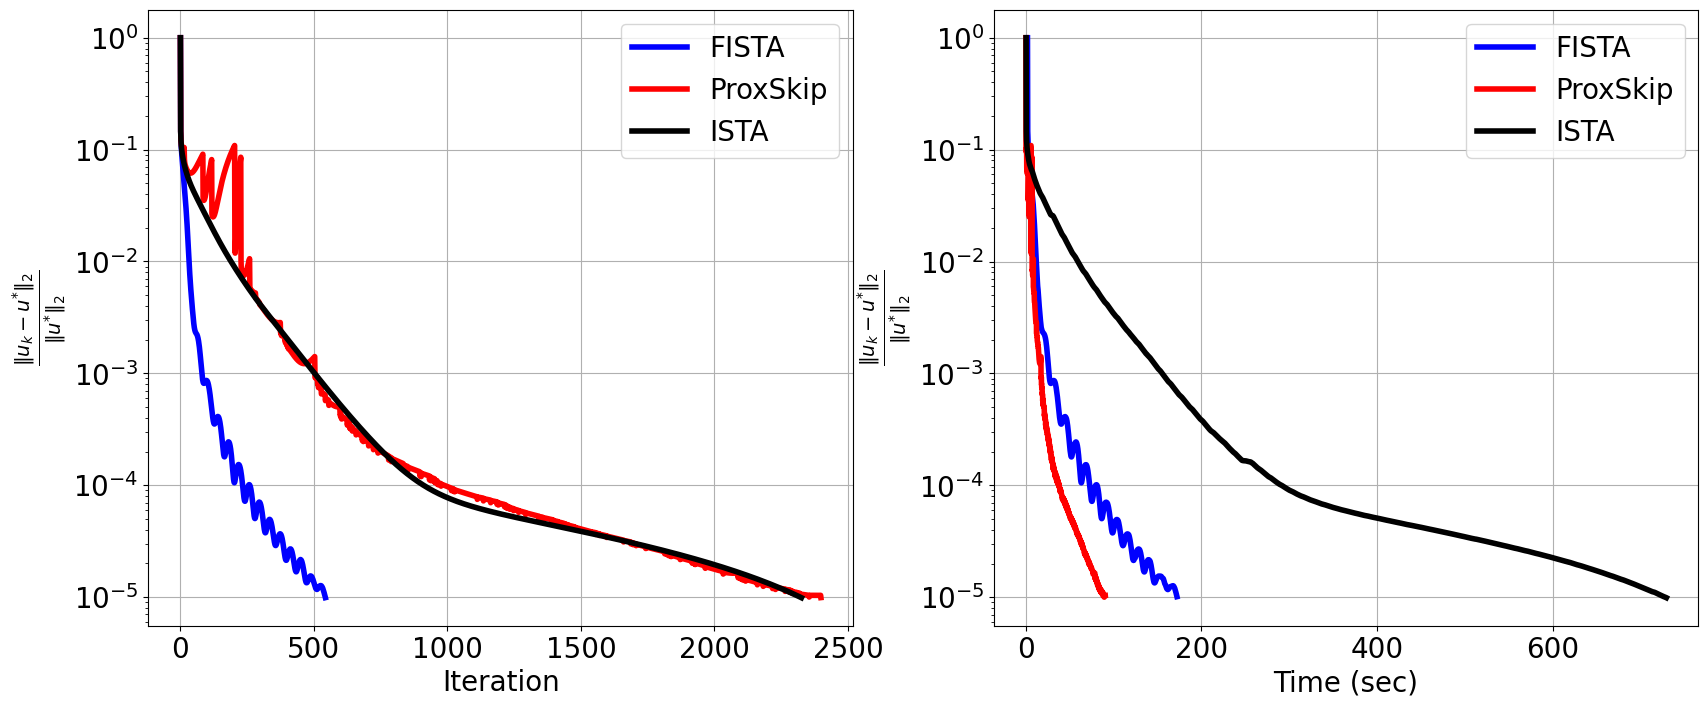

In [17]:
from cil.framework import ImageGeometry
from cil.optimisation.operators import LinearOperator, GradientOperator, BlurringOperator
from cil.optimisation.functions import Function
from cil.optimisation.functions import MixedL21Norm, LeastSquares, L2NormSquared, L1Norm, ZeroFunction
from cil.optimisation.algorithms import FISTA, ISTA
from cil.utilities import dataexample, noise
from cil.utilities.display import show2D
import numpy as np
import matplotlib.pyplot as plt
from cil.optimisation.algorithms import ProxSkip
from cil.optimisation.utilities import MetricsDiagnostics, StatisticsDiagnostics, AlgorithmDiagnostics, RSE
from cil.optimisation.functions import TotalVariation
import h5py
from skimage.metrics import peak_signal_noise_ratio as PSNR
from skimage.metrics import structural_similarity as SSIM
import numpy as np
import matplotlib.pyplot as plt
import imageio
import os
from TotalVariation import TotalVariationNew

import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 4
mpl.rcParams['lines.markersize'] = 12
mpl.rcParams['font.size'] = 20


class StoppingCriterion(AlgorithmDiagnostics):

    def __init__(self, epsilon):

        self.epsilon = epsilon
        super(StoppingCriterion, self).__init__(verbose=0)

        self.should_stop = False

    def _should_stop(self):

        return self.should_stop

    def __call__(self, algo):

        if algo.iteration==0:
            algo.should_stop = self._should_stop

        if (algo.rse[-1]<=self.epsilon):
            self.should_stop = True
            print("Stop at {} time {} ".format(algo.iteration, np.sum(algo.timing)))


def NRSE(x, y, **kwargs):
    """
     root squared error between two numpy arrays
    """
    return np.sqrt(np.sum(np.abs(x - y)**2))/np.sqrt(np.sum(x**2))

SSIM_dr = lambda x, y: SSIM(x, y, data_range=x.max()-x.min())
PSNR_dr = lambda x, y: PSNR(x, y, data_range=x.max()-x.min())


# # Load data
data = dataexample.SHAPES.get(data_dir = "/usr/local/share/cil")
ig = data.geometry


# Parameters for point spread function PSF (size and std)
ks          = 10;
ksigma      = 5;

# Create 1D PSF and 2D as outer product, then normalise.
w           = np.exp(-np.arange(-(ks-1)/2,(ks-1)/2+1)**2/(2*ksigma**2))
w.shape     = (ks,1)
PSF         = w*np.transpose(w)
PSF         = PSF/(PSF**2).sum()
PSF         = PSF/PSF.sum()

# Create blurring operator and apply to clean image to produce blurred and display.
BOP = BlurringOperator(PSF,ig)

# zarr fails in py311 gcolab
# blurred_noisy = zarr.load("noisy_blurry_shapes_var_0.001_seed_10.zarr")

with h5py.File('results/noisy_blurry_shapes_var_0.001_seed_10.h5', 'r') as hf:
    # Access the dataset by its name (replace 'array_name' with your dataset name)
    blurred_noisy = hf['array'][:]


blurred_noisy_cil = ig.allocate()
blurred_noisy_cil.fill(blurred_noisy)

alpha = 0.025

# compare vs pdhg precond
# zarr fails in py311 gcolab
# pdhg_precond_optimal_info = zarr.load("pdhg_optimal_precond_shapes_tv_alpha_{}.zarr".format(alpha))
# pdhg_precond_optimal_np = pdhg_precond_optimal_info["solution"]
# pdhg_precond_optimal_objective = pdhg_precond_optimal_info["objective"]

with h5py.File("results/pdhg_optimal_precond_shapes_tv_alpha_{}.h5".format(alpha), 'r') as hf:
    # Access the dataset by its name (replace 'array_name' with your dataset name)
    pdhg_precond_optimal_np = hf['array'][:]


pdhg_precond_optimal = ig.allocate()
pdhg_precond_optimal.fill(pdhg_precond_optimal_np)




G100 = alpha * TotalVariationNew(max_iteration=100, warm_start=True)
F = LeastSquares(A=BOP, b=blurred_noisy_cil, c=0.5)

cb1 = MetricsDiagnostics(reference_image=pdhg_precond_optimal,
                         metrics_dict={"rse":NRSE, "ssim":SSIM_dr, "psnr":PSNR_dr})


num_runs = 1
step_size = 1.
num_iterations = 3000
initial = ig.allocate()

probs = [0.05]

for run in range(num_runs):

        cb2 = StoppingCriterion(epsilon=0.99e-5)
        fista = FISTA(initial=initial, f=F, g=G100, max_iteration=num_iterations, update_objective_interval=1, step_size=step_size)
        fista.run(verbose=0, callback=[cb1, cb2])

        cb2 = StoppingCriterion(epsilon=0.99e-5)
        ista = ISTA(initial=initial, f=F, g=G100, max_iteration=num_iterations, update_objective_interval=1, step_size=step_size)
        ista.run(verbose=0, callback=[cb1, cb2])


        for prob in probs:

            cb2 = StoppingCriterion(epsilon=0.99e-5)
            proxskip = ProxSkip(initial = initial, f = F, step_size = step_size, g=G100,
                        update_objective_interval = 1, prob=prob, seed=40,
                        max_iteration = num_iterations)
            proxskip.run(verbose=0, callback=[cb1, cb2])

fig, axs = plt.subplots(1,2, figsize=(20,8))
axs[0].semilogy(fista.rse, label="FISTA", color="blue")
axs[0].semilogy(proxskip.rse, label="ProxSkip", color="red")
axs[0].semilogy(ista.rse, label="ISTA", color="black")
axs[0].set_ylabel(r"$\frac{\|u_{k} - u^{*}\|_{2}}{\|u^{*}\|_{2}}$")
axs[0].set_xlabel(r"Iteration")
axs[0].grid(which="major")
axs[0].legend()

axs[1].semilogy(np.cumsum(fista.timing), fista.rse[:-1], label="FISTA", color="blue")
axs[1].semilogy(np.cumsum(proxskip.timing), proxskip.rse[:-1], label="ProxSkip", color="red")
axs[1].semilogy(np.cumsum(ista.timing), ista.rse[:-1], label="ISTA", color="black")
axs[1].set_ylabel(r"$\frac{\|u_{k} - u^{*}\|_{2}}{\|u^{*}\|_{2}}$")
axs[1].set_xlabel(r"Time (sec)")
axs[1].grid(which="major")
axs[1].legend()
plt.show()